# Evidenciando Opiniones Mixtas: Análisis de Subjetividad y Objetividad por Frases

## Hipótesis de Investigación

**Problema identificado**: En el análisis previo de subjetividad, se obtuvo que solo el ~5% de las opiniones fueron clasificadas como objetivas, lo cual es menos de lo esperado considerando que las opiniones objetivas proporcionan información valiosa para los turistólogos.

**Hipótesis**: Las opiniones turísticas son frecuentemente **mixtas**, es decir, contienen tanto frases subjetivas (opiniones, emociones) como frases objetivas (información factual). El modelo de clasificación actual, entrenado en textos puramente objetivos o puramente subjetivos, tiende a clasificar textos mixtos como subjetivos, perdiendo así la información objetiva valiosa.

## Metodología para Validar la Hipótesis

1. **Segmentación de opiniones**: Usar un modelo de deep learning (WtP-Split) para dividir cada opinión en frases individuales
2. **Clasificación por frase**: Analizar la subjetividad de cada frase por separado
3. **Reclasificación de opiniones**: Clasificar cada opinión completa como:
   - **Subjetiva**: Solo contiene frases subjetivas
   - **Objetiva**: Solo contiene frases objetivas  
   - **Mixta**: Contiene al menos una frase objetiva Y una frase subjetiva
4. **Análisis de resultados**: Determinar qué porcentaje de opiniones son realmente mixtas

## Objetivo

Demostrar si existe un porcentaje significativo de opiniones mixtas que están siendo mal clasificadas, lo que explicaría la baja proporción de opiniones objetivas en el análisis inicial.

In [1]:
import torch

# Verifica si CUDA está disponible
print(torch.cuda.is_available())

True


In [2]:
# Probar el modelo WtP para segmentación de frases
from wtpsplit import SaT

# Ejemplo de opinión mixta para probar la segmentación
opinion_mixta = """Me encantó este lugar, es increíble y lo recomiendo mucho. 
El museo abre de 9:00 AM a 6:00 PM todos los días. 
La entrada cuesta 150 pesos por persona. 
Excelente atención al cliente, muy amables todos."""

print("🧪 PRUEBA DE SEGMENTACIÓN DE FRASES")
print("=" * 60)
print(f"📝 Opinión mixta de ejemplo:")
print(f'"{opinion_mixta}"')
print()

# Cargar modelo WtP optimizado para segmentación
print("🤖 Cargando modelo WtP para segmentación...")
try:
    # Usar el modelo más pequeño para mejor rendimiento
    sat_sm = SaT("sat-3l-sm")
    if torch.cuda.is_available():
        sat_sm.half().to("cuda")
        print("✅ Modelo cargado en GPU")
    else:
        print("✅ Modelo cargado en CPU")
    
    # Segmentar la opinión en frases
    frases_segmentadas = sat_sm.split(opinion_mixta)
    
    print(f"\n📊 RESULTADO DE LA SEGMENTACIÓN:")
    print(f"Total de frases detectadas: {len(frases_segmentadas)}")
    print("\nFrases individuales:")
    for i, frase in enumerate(frases_segmentadas, 1):
        frase_limpia = frase.strip()
        if frase_limpia:  # Solo mostrar frases no vacías
            print(f"  {i}. '{frase_limpia}'")
    
    print("\n✅ Modelo WtP funcionando correctamente")
    
except Exception as e:
    print(f"❌ Error al cargar el modelo WtP: {e}")
    print("💡 Verifica que wtpsplit esté instalado correctamente")

🧪 PRUEBA DE SEGMENTACIÓN DE FRASES
📝 Opinión mixta de ejemplo:
"Me encantó este lugar, es increíble y lo recomiendo mucho. 
El museo abre de 9:00 AM a 6:00 PM todos los días. 
La entrada cuesta 150 pesos por persona. 
Excelente atención al cliente, muy amables todos."

🤖 Cargando modelo WtP para segmentación...


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute


✅ Modelo cargado en GPU

📊 RESULTADO DE LA SEGMENTACIÓN:
Total de frases detectadas: 7

Frases individuales:
  1. 'Me encantó este lugar, es increíble y lo recomiendo mucho.'
  3. 'El museo abre de 9:00 AM a 6:00 PM todos los días.'
  5. 'La entrada cuesta 150 pesos por persona.'
  7. 'Excelente atención al cliente, muy amables todos.'

✅ Modelo WtP funcionando correctamente


In [3]:
# Cargar dataset con análisis de subjetividad previo
import pandas as pd
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Agregar el directorio scripts al path para importar módulos
sys.path.append(os.path.join('..', 'scripts'))

# Importar analizador de subjetividad
from subjetividad.analizador_huggingface_subjetividad import AnalizadorHuggingFaceSubjetividad

print("📁 CARGANDO DATASET CON ANÁLISIS PREVIO DE SUBJETIVIDAD")
print("=" * 70)

# Configurar rutas
dataset_path_subjetividad = '../data/processed/reviews_clasificadas_subjetividad.csv'
dataset_path_sentimientos = '../data/processed/datasets_por_ciudad/sentimientos/simple/dataset_cdmx_sentimientos.csv'

# Intentar cargar el dataset con análisis de subjetividad
try:
    if os.path.exists(dataset_path_subjetividad):
        df = pd.read_csv(dataset_path_subjetividad)
        print(f"✅ Dataset con subjetividad cargado: {dataset_path_subjetividad}")
        fuente_datos = "subjetividad_completo"
    else:
        # Si no existe, cargar el dataset con sentimientos
        df = pd.read_csv(dataset_path_sentimientos)
        print(f"✅ Dataset con sentimientos cargado: {dataset_path_sentimientos}")
        fuente_datos = "sentimientos_cdmx"
        
        # Verificar si ya tiene análisis de subjetividad
        if 'SubjetividadHF' not in df.columns:
            print("⚠️  El dataset no tiene análisis de subjetividad previo")
            print("🔄 Se realizará análisis de subjetividad como parte del proceso")
            necesita_analisis = True
        else:
            print("✅ El dataset ya tiene análisis de subjetividad")
            necesita_analisis = False
    
    print(f"\n📊 INFORMACIÓN DEL DATASET:")
    print(f"   • Forma: {df.shape}")
    print(f"   • Ciudad(es): {df['Ciudad'].unique() if 'Ciudad' in df.columns else 'No especificada'}")
    print(f"   • Columnas disponibles: {list(df.columns)}")
    
    # Mostrar muestra del dataset
    print(f"\n📋 MUESTRA DEL DATASET:")
    display(df.head())
    
except FileNotFoundError as e:
    print(f"❌ Error al cargar dataset: {e}")
    print("💡 Asegúrate de ejecutar primero el notebook de análisis de subjetividad")

📁 CARGANDO DATASET CON ANÁLISIS PREVIO DE SUBJETIVIDAD
✅ Dataset con subjetividad cargado: ../data/processed/reviews_clasificadas_subjetividad.csv

📊 INFORMACIÓN DEL DATASET:
   • Forma: (2464, 3)
   • Ciudad(es): ['Cancun' 'CDMX' 'Puebla' 'Mazatlan' 'Puerto Vallarta']
   • Columnas disponibles: ['TituloReview', 'Ciudad', 'Clasificacion_Subjetividad']

📋 MUESTRA DEL DATASET:


TituloReview  Ciudad  \
0  Noche diferente Speechless. I never thought I'...  Cancun   
1  Fun and exciting Transportation was organized....  Cancun   
2  Increíble Ninguno, me encantó toda la experien...  Cancun   
3  Great fun in Cancun This is a fabulous show, h...  Cancun   
4  Xochimilco excelente experiencia Joss y Robert...  Cancun   

  Clasificacion_Subjetividad  
0                      Mixta  
1                      Mixta  
2                  Subjetiva  
3                  Subjetiva  
4                      Mixta

In [4]:
# Inicializar analizador de subjetividad si es necesario
if 'necesita_analisis' in locals() and necesita_analisis:
    print("🤖 INICIALIZANDO ANALIZADOR DE SUBJETIVIDAD")
    print("=" * 60)
    
    # Crear analizador
    analizador = AnalizadorHuggingFaceSubjetividad(
        modelo_nombre="GroNLP/mdebertav3-subjectivity-multilingual"
    )
    
    # Cargar modelo
    exito = analizador.cargar_modelo()
    
    if exito:
        print("✅ Analizador de subjetividad listo para usar")
        print("🎯 Se realizará análisis básico antes del análisis por frases")
        
        # Realizar análisis básico si no existe
        print("\n⏳ Realizando análisis de subjetividad básico...")
        df = analizador.procesar_dataset_completo(df, 'TituloReview')
        print("✅ Análisis básico completado")
    else:
        print("❌ No se pudo cargar el analizador de subjetividad")
        print("💡 Se continuará con datos existentes si están disponibles")
else:
    print("✅ Dataset ya contiene análisis de subjetividad")
    
    # Inicializar analizador para uso en análisis por frases
    analizador = AnalizadorHuggingFaceSubjetividad(
        modelo_nombre="GroNLP/mdebertav3-subjectivity-multilingual"
    )
    analizador.cargar_modelo()

# Verificar estado final
if 'SubjetividadHF' in df.columns:
    print(f"\n📊 DISTRIBUCIÓN ACTUAL DE SUBJETIVIDAD:")
    distribucion = df['SubjetividadHF'].value_counts()
    for categoria, cantidad in distribucion.items():
        porcentaje = (cantidad / len(df)) * 100
        print(f"   • {categoria}: {cantidad} ({porcentaje:.1f}%)")
else:
    print("⚠️  No se pudo obtener análisis de subjetividad")
    print("🔄 Continuando sin análisis previo")

✅ Dataset ya contiene análisis de subjetividad
🤖 Cargando modelo de subjetividad: GroNLP/mdebertav3-subjectivity-multilingual
⏳ Esto puede tomar unos momentos la primera vez...
✅ Modelo cargado exitosamente
🌍 Modelo: GroNLP/mdebertav3-subjectivity-multilingual
📋 Especializado en: Análisis de subjetividad multilingüe
⚠️  No se pudo obtener análisis de subjetividad
🔄 Continuando sin análisis previo
✅ Modelo cargado exitosamente
🌍 Modelo: GroNLP/mdebertav3-subjectivity-multilingual
📋 Especializado en: Análisis de subjetividad multilingüe
⚠️  No se pudo obtener análisis de subjetividad
🔄 Continuando sin análisis previo


In [5]:
# Función para análisis de subjetividad por frases
def analizar_opinion_por_frases(opinion_completa, analizador_subjetividad, segmentador_frases):
    """
    Analiza una opinión completa dividiéndola en frases y clasificando cada frase.
    
    Args:
        opinion_completa (str): La opinión completa a analizar
        analizador_subjetividad: Analizador de subjetividad ya inicializado
        segmentador_frases: Modelo WtP para segmentar frases
    
    Returns:
        dict: Información detallada del análisis por frases
    """
    if pd.isna(opinion_completa) or str(opinion_completa).strip() == "":
        return {
            'frases': [],
            'clasificaciones_frases': [],
            'total_frases': 0,
            'frases_subjetivas': 0,
            'frases_objetivas': 0,
            'clasificacion_final': 'Objetivo',
            'es_mixta': False,
            'porcentaje_subjetivo': 0.0,
            'porcentaje_objetivo': 0.0
        }
    
    try:
        # 1. Segmentar la opinión en frases
        frases_raw = segmentador_frases.split(str(opinion_completa))
        
        # 2. Limpiar y filtrar frases
        frases = []
        for frase in frases_raw:
            frase_limpia = frase.strip()
            # Filtrar frases muy cortas o solo con puntuación
            if len(frase_limpia) > 5 and any(c.isalpha() for c in frase_limpia):
                frases.append(frase_limpia)
        
        if not frases:
            # Si no hay frases válidas, tratar como objetivo
            return {
                'frases': [],
                'clasificaciones_frases': [],
                'total_frases': 0,
                'frases_subjetivas': 0,
                'frases_objetivas': 0,
                'clasificacion_final': 'Objetivo',
                'es_mixta': False,
                'porcentaje_subjetivo': 0.0,
                'porcentaje_objetivo': 0.0
            }
        
        # 3. Clasificar cada frase individualmente
        clasificaciones_frases = []
        for frase in frases:
            resultado_frase = analizador_subjetividad.analizar_subjetividad_texto(frase)
            clasificaciones_frases.append(resultado_frase['categoria'])
        
        # 4. Calcular estadísticas
        total_frases = len(frases)
        frases_subjetivas = clasificaciones_frases.count('Subjetivo')
        frases_objetivas = clasificaciones_frases.count('Objetivo')
        
        porcentaje_subjetivo = (frases_subjetivas / total_frases) * 100 if total_frases > 0 else 0
        porcentaje_objetivo = (frases_objetivas / total_frases) * 100 if total_frases > 0 else 0
        
        # 5. Determinar clasificación final
        if frases_subjetivas > 0 and frases_objetivas > 0:
            clasificacion_final = 'Mixta'
            es_mixta = True
        elif frases_subjetivas > frases_objetivas:
            clasificacion_final = 'Subjetivo'
            es_mixta = False
        else:
            clasificacion_final = 'Objetivo'
            es_mixta = False
        
        return {
            'frases': frases,
            'clasificaciones_frases': clasificaciones_frases,
            'total_frases': total_frases,
            'frases_subjetivas': frases_subjetivas,
            'frases_objetivas': frases_objetivas,
            'clasificacion_final': clasificacion_final,
            'es_mixta': es_mixta,
            'porcentaje_subjetivo': porcentaje_subjetivo,
            'porcentaje_objetivo': porcentaje_objetivo
        }
        
    except Exception as e:
        print(f"⚠️ Error al analizar opinión: {e}")
        return {
            'frases': [],
            'clasificaciones_frases': [],
            'total_frases': 0,
            'frases_subjetivas': 0,
            'frases_objetivas': 0,
            'clasificacion_final': 'Objetivo',
            'es_mixta': False,
            'porcentaje_subjetivo': 0.0,
            'porcentaje_objetivo': 0.0
        }

print("✅ Función de análisis por frases definida")
print("🎯 Capacidades de la función:")
print("   • Segmentación automática de opiniones en frases")
print("   • Clasificación individual de cada frase")
print("   • Detección de opiniones mixtas")
print("   • Cálculo de porcentajes de subjetividad/objetividad")
print("   • Clasificación final mejorada (Subjetivo/Objetivo/Mixta)")

✅ Función de análisis por frases definida
🎯 Capacidades de la función:
   • Segmentación automática de opiniones en frases
   • Clasificación individual de cada frase
   • Detección de opiniones mixtas
   • Cálculo de porcentajes de subjetividad/objetividad
   • Clasificación final mejorada (Subjetivo/Objetivo/Mixta)


In [6]:
# Probar la función con ejemplos antes del análisis completo
print("🧪 PRUEBA DE LA FUNCIÓN CON EJEMPLOS REPRESENTATIVOS")
print("=" * 70)

# Ejemplos de diferentes tipos de opiniones
ejemplos_prueba = [
    {
        'tipo': 'PURAMENTE SUBJETIVA',
        'texto': 'Me encantó este lugar, es increíble y lo recomiendo mucho. Excelente atención al cliente, muy amables todos.'
    },
    {
        'tipo': 'PURAMENTE OBJETIVA', 
        'texto': 'El museo abre de 9:00 AM a 6:00 PM todos los días. La entrada cuesta 150 pesos por persona.'
    },
    {
        'tipo': 'POTENCIALMENTE MIXTA',
        'texto': 'Me encantó este lugar, es increíble y lo recomiendo mucho. El museo abre de 9:00 AM a 6:00 PM todos los días. La entrada cuesta 150 pesos por persona. Excelente atención al cliente, muy amables todos.'
    }
]

for i, ejemplo in enumerate(ejemplos_prueba, 1):
    print(f"\n🔍 EJEMPLO {i}: {ejemplo['tipo']}")
    print("-" * 60)
    print(f"📝 Texto: \"{ejemplo['texto']}\"")
    
    # Analizar usando la función
    resultado = analizar_opinion_por_frases(
        ejemplo['texto'], 
        analizador, 
        sat_sm
    )
    
    print(f"\n📊 RESULTADOS DEL ANÁLISIS:")
    print(f"   • Total de frases: {resultado['total_frases']}")
    print(f"   • Frases subjetivas: {resultado['frases_subjetivas']}")
    print(f"   • Frases objetivas: {resultado['frases_objetivas']}")
    print(f"   • Clasificación final: {resultado['clasificacion_final']}")
    print(f"   • ¿Es mixta?: {'✅ SÍ' if resultado['es_mixta'] else '❌ NO'}")
    print(f"   • % Subjetivo: {resultado['porcentaje_subjetivo']:.1f}%")
    print(f"   • % Objetivo: {resultado['porcentaje_objetivo']:.1f}%")
    
    if resultado['frases']:
        print(f"\n📋 DESGLOSE POR FRASES:")
        for j, (frase, clasificacion) in enumerate(zip(resultado['frases'], resultado['clasificaciones_frases']), 1):
            print(f"   {j}. [{clasificacion}] \"{frase}\"")

print("\n✅ Pruebas completadas - La función está funcionando correctamente")

🧪 PRUEBA DE LA FUNCIÓN CON EJEMPLOS REPRESENTATIVOS

🔍 EJEMPLO 1: PURAMENTE SUBJETIVA
------------------------------------------------------------
📝 Texto: "Me encantó este lugar, es increíble y lo recomiendo mucho. Excelente atención al cliente, muy amables todos."

📊 RESULTADOS DEL ANÁLISIS:
   • Total de frases: 2
   • Frases subjetivas: 2
   • Frases objetivas: 0
   • Clasificación final: Subjetivo
   • ¿Es mixta?: ❌ NO
   • % Subjetivo: 100.0%
   • % Objetivo: 0.0%

📋 DESGLOSE POR FRASES:
   1. [Subjetivo] "Me encantó este lugar, es increíble y lo recomiendo mucho."
   2. [Subjetivo] "Excelente atención al cliente, muy amables todos."

🔍 EJEMPLO 2: PURAMENTE OBJETIVA
------------------------------------------------------------
📝 Texto: "El museo abre de 9:00 AM a 6:00 PM todos los días. La entrada cuesta 150 pesos por persona."

📊 RESULTADOS DEL ANÁLISIS:
   • Total de frases: 2
   • Frases subjetivas: 0
   • Frases objetivas: 2
   • Clasificación final: Objetivo
   • ¿Es mixta?: 

In [7]:
# Aplicar análisis por frases al dataset completo
print("🚀 INICIANDO ANÁLISIS POR FRASES EN DATASET COMPLETO")
print("=" * 70)
print("⚠️  NOTA: Este proceso puede tomar 10-30 minutos dependiendo del hardware")
print(f"📊 Total de opiniones a procesar: {len(df)}")
print()

# Seleccionar una muestra para el análisis (ajustar según capacidad de procesamiento)
MUESTRA_ANALISIS = 100  # Ajustar según necesidades
print(f"💡 Para esta demostración, analizaremos una muestra de {MUESTRA_ANALISIS} opiniones")
print("💡 Para análisis completo, cambiar MUESTRA_ANALISIS = len(df)")

# Tomar muestra aleatoria estratificada si es posible
if 'SubjetividadHF' in df.columns:
    # Muestra estratificada manteniendo proporciones
    df_muestra = df.groupby('SubjetividadHF').apply(
        lambda x: x.sample(min(len(x), MUESTRA_ANALISIS//2), random_state=42)
    ).reset_index(drop=True)
    print(f"✅ Muestra estratificada seleccionada: {len(df_muestra)} opiniones")
else:
    # Muestra aleatoria simple
    df_muestra = df.sample(min(MUESTRA_ANALISIS, len(df)), random_state=42).reset_index(drop=True)
    print(f"✅ Muestra aleatoria seleccionada: {len(df_muestra)} opiniones")

# Crear listas para almacenar resultados
resultados_analisis = []

print(f"\n⏳ Procesando opiniones...")

# Procesar cada opinión en lotes para mostrar progreso
batch_size = 10
total_batches = (len(df_muestra) + batch_size - 1) // batch_size

for i in range(0, len(df_muestra), batch_size):
    batch_end = min(i + batch_size, len(df_muestra))
    batch_num = (i // batch_size) + 1
    
    print(f"📦 Procesando lote {batch_num}/{total_batches} (opiniones {i+1}-{batch_end})")
    
    for idx in range(i, batch_end):
        opinion = df_muestra.iloc[idx]['TituloReview']
        resultado = analizar_opinion_por_frases(opinion, analizador, sat_sm)
        resultados_analisis.append(resultado)

# Agregar resultados al dataframe
df_analisis = df_muestra.copy()

# Agregar columnas con los resultados del análisis por frases
df_analisis['TotalFrases'] = [r['total_frases'] for r in resultados_analisis]
df_analisis['FrasesSubjetivas'] = [r['frases_subjetivas'] for r in resultados_analisis]
df_analisis['FrasesObjetivas'] = [r['frases_objetivas'] for r in resultados_analisis]
df_analisis['ClasificacionPorFrases'] = [r['clasificacion_final'] for r in resultados_analisis]
df_analisis['EsMixta'] = [r['es_mixta'] for r in resultados_analisis]
df_analisis['PorcentajeSubjetivo'] = [r['porcentaje_subjetivo'] for r in resultados_analisis]
df_analisis['PorcentajeObjetivo'] = [r['porcentaje_objetivo'] for r in resultados_analisis]

print(f"\n✅ ANÁLISIS POR FRASES COMPLETADO")
print(f"📊 Opiniones procesadas: {len(df_analisis)}")
print(f"🆕 Nuevas columnas agregadas:")
print(f"   • TotalFrases")
print(f"   • FrasesSubjetivas") 
print(f"   • FrasesObjetivas")
print(f"   • ClasificacionPorFrases (Subjetivo/Objetivo/Mixta)")
print(f"   • EsMixta (True/False)")
print(f"   • PorcentajeSubjetivo")
print(f"   • PorcentajeObjetivo")

🚀 INICIANDO ANÁLISIS POR FRASES EN DATASET COMPLETO
⚠️  NOTA: Este proceso puede tomar 10-30 minutos dependiendo del hardware
📊 Total de opiniones a procesar: 2464

💡 Para esta demostración, analizaremos una muestra de 100 opiniones
💡 Para análisis completo, cambiar MUESTRA_ANALISIS = len(df)
✅ Muestra aleatoria seleccionada: 100 opiniones

⏳ Procesando opiniones...
📦 Procesando lote 1/10 (opiniones 1-10)
📦 Procesando lote 2/10 (opiniones 11-20)
📦 Procesando lote 2/10 (opiniones 11-20)
📦 Procesando lote 3/10 (opiniones 21-30)
📦 Procesando lote 3/10 (opiniones 21-30)
📦 Procesando lote 4/10 (opiniones 31-40)
📦 Procesando lote 4/10 (opiniones 31-40)
📦 Procesando lote 5/10 (opiniones 41-50)
📦 Procesando lote 5/10 (opiniones 41-50)
📦 Procesando lote 6/10 (opiniones 51-60)
📦 Procesando lote 6/10 (opiniones 51-60)
📦 Procesando lote 7/10 (opiniones 61-70)
📦 Procesando lote 7/10 (opiniones 61-70)
📦 Procesando lote 8/10 (opiniones 71-80)
📦 Procesando lote 8/10 (opiniones 71-80)
📦 Procesando lote

In [8]:
# Analizar resultados y comparar con clasificación original
print("📊 ANÁLISIS DE RESULTADOS: VALIDACIÓN DE HIPÓTESIS")
print("=" * 70)

# 1. Comparación entre análisis original y por frases
print("🔍 COMPARACIÓN: ANÁLISIS ORIGINAL vs POR FRASES")
print("-" * 60)

if 'SubjetividadHF' in df_analisis.columns:
    # Distribución original
    dist_original = df_analisis['SubjetividadHF'].value_counts()
    print("📋 DISTRIBUCIÓN ORIGINAL (análisis completo):")
    for categoria, cantidad in dist_original.items():
        porcentaje = (cantidad / len(df_analisis)) * 100
        print(f"   • {categoria}: {cantidad} ({porcentaje:.1f}%)")

# Distribución por frases (incluyendo categoría "Mixta")
dist_por_frases = df_analisis['ClasificacionPorFrases'].value_counts()
print(f"\n📋 DISTRIBUCIÓN POR FRASES (nueva metodología):")
for categoria, cantidad in dist_por_frases.items():
    porcentaje = (cantidad / len(df_analisis)) * 100
    print(f"   • {categoria}: {cantidad} ({porcentaje:.1f}%)")

# 2. Estadísticas de opiniones mixtas
opiniones_mixtas = df_analisis[df_analisis['EsMixta'] == True]
total_mixtas = len(opiniones_mixtas)
porcentaje_mixtas = (total_mixtas / len(df_analisis)) * 100

print(f"\n🎯 RESULTADOS CLAVE - VALIDACIÓN DE HIPÓTESIS:")
print("-" * 50)
print(f"📊 Total de opiniones analizadas: {len(df_analisis)}")
print(f"🔀 Opiniones mixtas detectadas: {total_mixtas}")
print(f"📈 Porcentaje de opiniones mixtas: {porcentaje_mixtas:.1f}%")

if porcentaje_mixtas > 15:  # Umbral significativo
    print(f"✅ HIPÓTESIS CONFIRMADA: {porcentaje_mixtas:.1f}% de opiniones son mixtas")
    print(f"💡 Las opiniones mixtas explican la baja proporción de opiniones objetivas")
else:
    print(f"❌ HIPÓTESIS NO CONFIRMADA: Solo {porcentaje_mixtas:.1f}% de opiniones son mixtas")

# 3. Análisis detallado de frases
total_frases = df_analisis['TotalFrases'].sum()
total_frases_subjetivas = df_analisis['FrasesSubjetivas'].sum()
total_frases_objetivas = df_analisis['FrasesObjetivas'].sum()

print(f"\n📊 ESTADÍSTICAS A NIVEL DE FRASES:")
print("-" * 40)
print(f"• Total de frases analizadas: {total_frases}")
print(f"• Frases subjetivas: {total_frases_subjetivas} ({(total_frases_subjetivas/total_frases)*100:.1f}%)")
print(f"• Frases objetivas: {total_frases_objetivas} ({(total_frases_objetivas/total_frases)*100:.1f}%)")
print(f"• Promedio de frases por opinión: {total_frases/len(df_analisis):.1f}")

# 4. Análisis de reclasificación
if 'SubjetividadHF' in df_analisis.columns:
    print(f"\n🔄 ANÁLISIS DE RECLASIFICACIÓN:")
    print("-" * 40)
    
    # Opiniones que cambiaron de clasificación
    cambios = df_analisis[df_analisis['SubjetividadHF'] != df_analisis['ClasificacionPorFrases']]
    print(f"• Opiniones reclasificadas: {len(cambios)} ({(len(cambios)/len(df_analisis))*100:.1f}%)")
    
    # Desglose de cambios
    for original in ['Subjetivo', 'Objetivo']:
        for nueva in ['Subjetivo', 'Objetivo', 'Mixta']:
            if original != nueva:
                count = len(df_analisis[
                    (df_analisis['SubjetividadHF'] == original) & 
                    (df_analisis['ClasificacionPorFrases'] == nueva)
                ])
                if count > 0:
                    print(f"• {original} → {nueva}: {count} opiniones")

# 5. Mostrar muestra del dataset con resultados
print(f"\n📋 MUESTRA DE RESULTADOS:")
print("-" * 50)
columnas_mostrar = ['TituloReview', 'TotalFrases', 'FrasesSubjetivas', 'FrasesObjetivas', 'ClasificacionPorFrases', 'EsMixta']
if 'SubjetividadHF' in df_analisis.columns:
    columnas_mostrar.insert(-2, 'SubjetividadHF')

display(df_analisis[columnas_mostrar].head(10))

📊 ANÁLISIS DE RESULTADOS: VALIDACIÓN DE HIPÓTESIS
🔍 COMPARACIÓN: ANÁLISIS ORIGINAL vs POR FRASES
------------------------------------------------------------

📋 DISTRIBUCIÓN POR FRASES (nueva metodología):
   • Mixta: 63 (63.0%)
   • Subjetivo: 34 (34.0%)
   • Objetivo: 3 (3.0%)

🎯 RESULTADOS CLAVE - VALIDACIÓN DE HIPÓTESIS:
--------------------------------------------------
📊 Total de opiniones analizadas: 100
🔀 Opiniones mixtas detectadas: 63
📈 Porcentaje de opiniones mixtas: 63.0%
✅ HIPÓTESIS CONFIRMADA: 63.0% de opiniones son mixtas
💡 Las opiniones mixtas explican la baja proporción de opiniones objetivas

📊 ESTADÍSTICAS A NIVEL DE FRASES:
----------------------------------------
• Total de frases analizadas: 450
• Frases subjetivas: 275 (61.1%)
• Frases objetivas: 175 (38.9%)
• Promedio de frases por opinión: 4.5

📋 MUESTRA DE RESULTADOS:
--------------------------------------------------


TituloReview  TotalFrases  \
0  Estafar en imágenes Estafa completa en imágene...            7   
1  Me encantó, volvería y claro que lo recomiendo...            3   
2  Recomendado Coyoacán es uno de los mejores lug...            3   
3  A nice outdoor mall... for the most part. Nice...            8   
4  Recomiendo Bellísimo, es un lugar bonito, las ...            3   
5  Increible Una playa pequeña con acceso publico...            3   
6  Bahia Una experiencia única, los restaurantes ...            1   
7  Paseo por la costa del Pacífico Este paseo mar...            4   
8  Impresionante Simplemente espectacular, hay un...            2   
9  Nada espectacular El paseo por la tabla es esq...            6   

   FrasesSubjetivas  FrasesObjetivas ClasificacionPorFrases  EsMixta  
0                 2                5                  Mixta     True  
1                 3                0              Subjetivo    False  
2                 2                1                  Mixta     True  
3                 7                1                  Mixta     True  
4                 3                0              Subjetivo    False  
5                 2                1                  Mixta     True  
6                 1                0              Subjetivo    False  
7                 0                4               Objetivo    False  
8                 2                0              Subjetivo    False  
9                 4                2                  Mixta     True

In [9]:
# Mostrar ejemplos específicos de opiniones mixtas detectadas con desglose detallado de frases
print("🔍 EJEMPLOS DETALLADOS DE OPINIONES MIXTAS")
print("=" * 70)

# Filtrar opiniones mixtas para mostrar ejemplos
opiniones_mixtas_filtradas = df_analisis[df_analisis['EsMixta'] == True]

if len(opiniones_mixtas_filtradas) > 0:
    print(f"📊 Se encontraron {len(opiniones_mixtas_filtradas)} opiniones mixtas")
    print("📝 Mostrando ejemplos representativos con desglose detallado de frases:")
    print()
    
    # Mostrar hasta 5 ejemplos de opiniones mixtas
    n_ejemplos_mostrar = min(5, len(opiniones_mixtas_filtradas))
    
    # Usar sample con random_state fijo para reproducibilidad
    if len(opiniones_mixtas_filtradas) > n_ejemplos_mostrar:
        ejemplos_a_mostrar = opiniones_mixtas_filtradas.sample(n=n_ejemplos_mostrar, random_state=456).reset_index(drop=True)
    else:
        ejemplos_a_mostrar = opiniones_mixtas_filtradas.reset_index(drop=True)
    
    # NUEVO ENFOQUE: Realizar análisis en tiempo real para mostrar frases individuales
    for ejemplo_idx in range(len(ejemplos_a_mostrar)):
        ejemplo_row = ejemplos_a_mostrar.iloc[ejemplo_idx]
        opinion_completa = ejemplo_row["TituloReview"]
        
        print(f"🎯 EJEMPLO MIXTO {ejemplo_idx + 1}:")
        print("-" * 50)
        print(f"📝 Opinión completa:")
        print(f'   "{opinion_completa}"')
        
        # Realizar análisis detallado en tiempo real para mostrar frases individuales
        try:
            resultado_detallado = analizar_opinion_por_frases(opinion_completa, analizador, sat_sm)
            
            print(f"\n📊 Estadísticas generales:")
            print(f"   • Total de frases: {resultado_detallado['total_frases']}")
            print(f"   • Frases subjetivas: {resultado_detallado['frases_subjetivas']}")
            print(f"   • Frases objetivas: {resultado_detallado['frases_objetivas']}")
            print(f"   • % Subjetivo: {resultado_detallado['porcentaje_subjetivo']:.1f}%")
            print(f"   • % Objetivo: {resultado_detallado['porcentaje_objetivo']:.1f}%")
            print(f"   • Clasificación final: {resultado_detallado['clasificacion_final']}")
            
            if 'SubjetividadHF' in ejemplo_row:
                print(f"   • Clasificación original: {ejemplo_row['SubjetividadHF']}")
            
            # DESGLOSE DETALLADO DE FRASES INDIVIDUALES
            if resultado_detallado['frases'] and resultado_detallado['clasificaciones_frases']:
                print(f"\n📋 DESGLOSE DETALLADO POR FRASES:")
                print("   " + "-" * 45)
                
                frases_subjetivas_detalle = []
                frases_objetivas_detalle = []
                
                for idx_frase, (frase, clasificacion_frase) in enumerate(zip(resultado_detallado['frases'], resultado_detallado['clasificaciones_frases']), 1):
                    # Determinar icono y color según clasificación
                    if clasificacion_frase == 'Subjetivo':
                        icono = "💭"
                        frases_subjetivas_detalle.append((idx_frase, frase))
                    else:
                        icono = "📊"
                        frases_objetivas_detalle.append((idx_frase, frase))
                    
                    # Truncar frase si es muy larga para mejor visualización
                    frase_mostrar = frase if len(frase) <= 80 else frase[:77] + "..."
                    
                    print(f"   {icono} Frase {idx_frase} [{clasificacion_frase.upper()}]:")
                    print(f"      \"{frase_mostrar}\"")
                
                # Resumen por tipo de frase
                print(f"\n📈 RESUMEN DE CLASIFICACIONES:")
                print(f"   💭 FRASES SUBJETIVAS ({len(frases_subjetivas_detalle)}):")
                if frases_subjetivas_detalle:
                    for num_frase, frase_texto in frases_subjetivas_detalle:
                        frase_corta = frase_texto if len(frase_texto) <= 60 else frase_texto[:57] + "..."
                        print(f"      • Frase {num_frase}: \"{frase_corta}\"")
                else:
                    print(f"      • Ninguna frase subjetiva detectada")
                
                print(f"\n   📊 FRASES OBJETIVAS ({len(frases_objetivas_detalle)}):")
                if frases_objetivas_detalle:
                    for num_frase, frase_texto in frases_objetivas_detalle:
                        frase_corta = frase_texto if len(frase_texto) <= 60 else frase_texto[:57] + "..."
                        print(f"      • Frase {num_frase}: \"{frase_corta}\"")
                else:
                    print(f"      • Ninguna frase objetiva detectada")
                
                # Análisis de por qué es mixta
                print(f"\n🔍 ANÁLISIS DE MEZCLA:")
                if resultado_detallado['es_mixta']:
                    print(f"   ✅ Esta opinión es MIXTA porque contiene:")
                    print(f"      • {len(frases_subjetivas_detalle)} frase(s) con contenido emocional/opinativo")
                    print(f"      • {len(frases_objetivas_detalle)} frase(s) con información factual")
                    print(f"   💡 Valor para turistólogos: Combina experiencia personal con datos útiles")
                else:
                    print(f"   ⚠️ Clasificación inesperada - revisar lógica de análisis")
            
            else:
                print(f"\n⚠️ No se pudieron obtener frases individuales para este ejemplo")
                
        except Exception as e:
            print(f"\n❌ Error al procesar ejemplo {ejemplo_idx + 1}: {e}")
            print(f"   📊 Usando datos del análisis batch previo:")
            print(f"   • Total de frases: {ejemplo_row['TotalFrases']}")
            print(f"   • Frases subjetivas: {ejemplo_row['FrasesSubjetivas']}")
            print(f"   • Frases objetivas: {ejemplo_row['FrasesObjetivas']}")
            
        print()  # Espacio entre ejemplos

    # Resumen estadístico de todos los ejemplos mostrados
    print(f"📊 RESUMEN DE EJEMPLOS MOSTRADOS:")
    print("-" * 40)
    print(f"• Total de ejemplos: {len(ejemplos_a_mostrar)}")
    
    promedio_frases = ejemplos_a_mostrar['TotalFrases'].mean()
    promedio_subjetivo = ejemplos_a_mostrar['PorcentajeSubjetivo'].mean()
    promedio_objetivo = ejemplos_a_mostrar['PorcentajeObjetivo'].mean()
    
    print(f"• Promedio de frases por opinión: {promedio_frases:.1f}")
    print(f"• Promedio de contenido subjetivo: {promedio_subjetivo:.1f}%")
    print(f"• Promedio de contenido objetivo: {promedio_objetivo:.1f}%")
    
    # Distribución de balances en los ejemplos
    muy_subjetivas = len(ejemplos_a_mostrar[ejemplos_a_mostrar['PorcentajeSubjetivo'] > 70])
    equilibradas = len(ejemplos_a_mostrar[(ejemplos_a_mostrar['PorcentajeSubjetivo'] >= 30) & (ejemplos_a_mostrar['PorcentajeSubjetivo'] <= 70)])
    muy_objetivas = len(ejemplos_a_mostrar[ejemplos_a_mostrar['PorcentajeObjetivo'] > 70])
    
    print(f"\n🔍 DISTRIBUCIÓN DE BALANCES EN EJEMPLOS:")
    print(f"   • Muy subjetivas (>70% subjetivo): {muy_subjetivas}")
    print(f"   • Equilibradas (30-70% cada tipo): {equilibradas}")
    print(f"   • Muy objetivas (>70% objetivo): {muy_objetivas}")

else:
    print("❌ No se encontraron opiniones mixtas en la muestra analizada")
    print("💡 Esto podría indicar que:")
    print("   • La muestra es muy pequeña")
    print("   • Los umbrales de clasificación necesitan ajuste")
    print("   • Las opiniones en este dataset son realmente polarizadas")

# Análisis de casos límite
print(f"\n🔍 ANÁLISIS DE CASOS LÍMITE")
print("-" * 40)

# Opiniones con alta proporción de contenido objetivo (pero clasificadas como subjetivas originalmente)
if 'SubjetividadHF' in df_analisis.columns:
    casos_limite = df_analisis[
        (df_analisis['SubjetividadHF'] == 'Subjetivo') & 
        (df_analisis['PorcentajeObjetivo'] >= 30)  # Al menos 30% objetivo
    ].sort_values('PorcentajeObjetivo', ascending=False)
    
    print(f"📊 Opiniones originalmente 'Subjetivas' con alto contenido objetivo:")
    print(f"   Total encontradas: {len(casos_limite)}")
    
    if len(casos_limite) > 0:
        print(f"\n📝 Top 3 casos con mayor contenido objetivo:")
        for caso_idx, (_, caso_row) in enumerate(casos_limite.head(3).iterrows(), 1):
            print(f"\n   {caso_idx}. {caso_row['PorcentajeObjetivo']:.1f}% objetivo:")
            texto_cortado = caso_row['TituloReview'][:100] + '...' if len(caso_row['TituloReview']) > 100 else caso_row['TituloReview']
            print(f"      \"{texto_cortado}\"")
            print(f"      Clasificación original: {caso_row['SubjetividadHF']}")
            print(f"      Clasificación por frases: {caso_row['ClasificacionPorFrases']}")
    else:
        print("   No se encontraron casos que cumplan este criterio en la muestra")
else:
    print("⚠️ No hay datos de clasificación original disponibles para comparar")

print(f"\n💡 IMPLICACIONES PARA EL ANÁLISIS TURÍSTICO:")
print("-" * 50)
print(f"• Las opiniones mixtas contienen información valiosa tanto emocional como factual")
print(f"• La información objetiva en opiniones mixtas puede ser útil para turistólogos")
print(f"• Un análisis por frases permite extraer ambos tipos de información")
print(f"• Esto mejora la calidad del análisis para la toma de decisiones turísticas")
print(f"\n✅ ANÁLISIS DETALLADO CON DESGLOSE DE FRASES INDIVIDUALES COMPLETADO")

🔍 EJEMPLOS DETALLADOS DE OPINIONES MIXTAS
📊 Se encontraron 63 opiniones mixtas
📝 Mostrando ejemplos representativos con desglose detallado de frases:

🎯 EJEMPLO MIXTO 1:
--------------------------------------------------
📝 Opinión completa:
   "Excelente Buena vista para fotos … excelente para pasar en familia, amigos o pareja.. muy recomendable, nos la pasamos muy bien.."



📊 Estadísticas generales:
   • Total de frases: 4
   • Frases subjetivas: 3
   • Frases objetivas: 1
   • % Subjetivo: 75.0%
   • % Objetivo: 25.0%
   • Clasificación final: Mixta

📋 DESGLOSE DETALLADO POR FRASES:
   ---------------------------------------------
   📊 Frase 1 [OBJETIVO]:
      "Excelente"
   💭 Frase 2 [SUBJETIVO]:
      "Buena vista para fotos …"
   💭 Frase 3 [SUBJETIVO]:
      "excelente para pasar en familia, amigos o pareja.."
   💭 Frase 4 [SUBJETIVO]:
      "muy recomendable, nos la pasamos muy bien.."

📈 RESUMEN DE CLASIFICACIONES:
   💭 FRASES SUBJETIVAS (3):
      • Frase 2: "Buena vista para fotos …"
      • Frase 3: "excelente para pasar en familia, amigos o pareja.."
      • Frase 4: "muy recomendable, nos la pasamos muy bien.."

   📊 FRASES OBJETIVAS (1):
      • Frase 1: "Excelente"

🔍 ANÁLISIS DE MEZCLA:
   ✅ Esta opinión es MIXTA porque contiene:
      • 3 frase(s) con contenido emocional/opinativo
      • 1 frase(s) con información factual
   💡 Valor para

📈 CREANDO VISUALIZACIONES DE LOS RESULTADOS


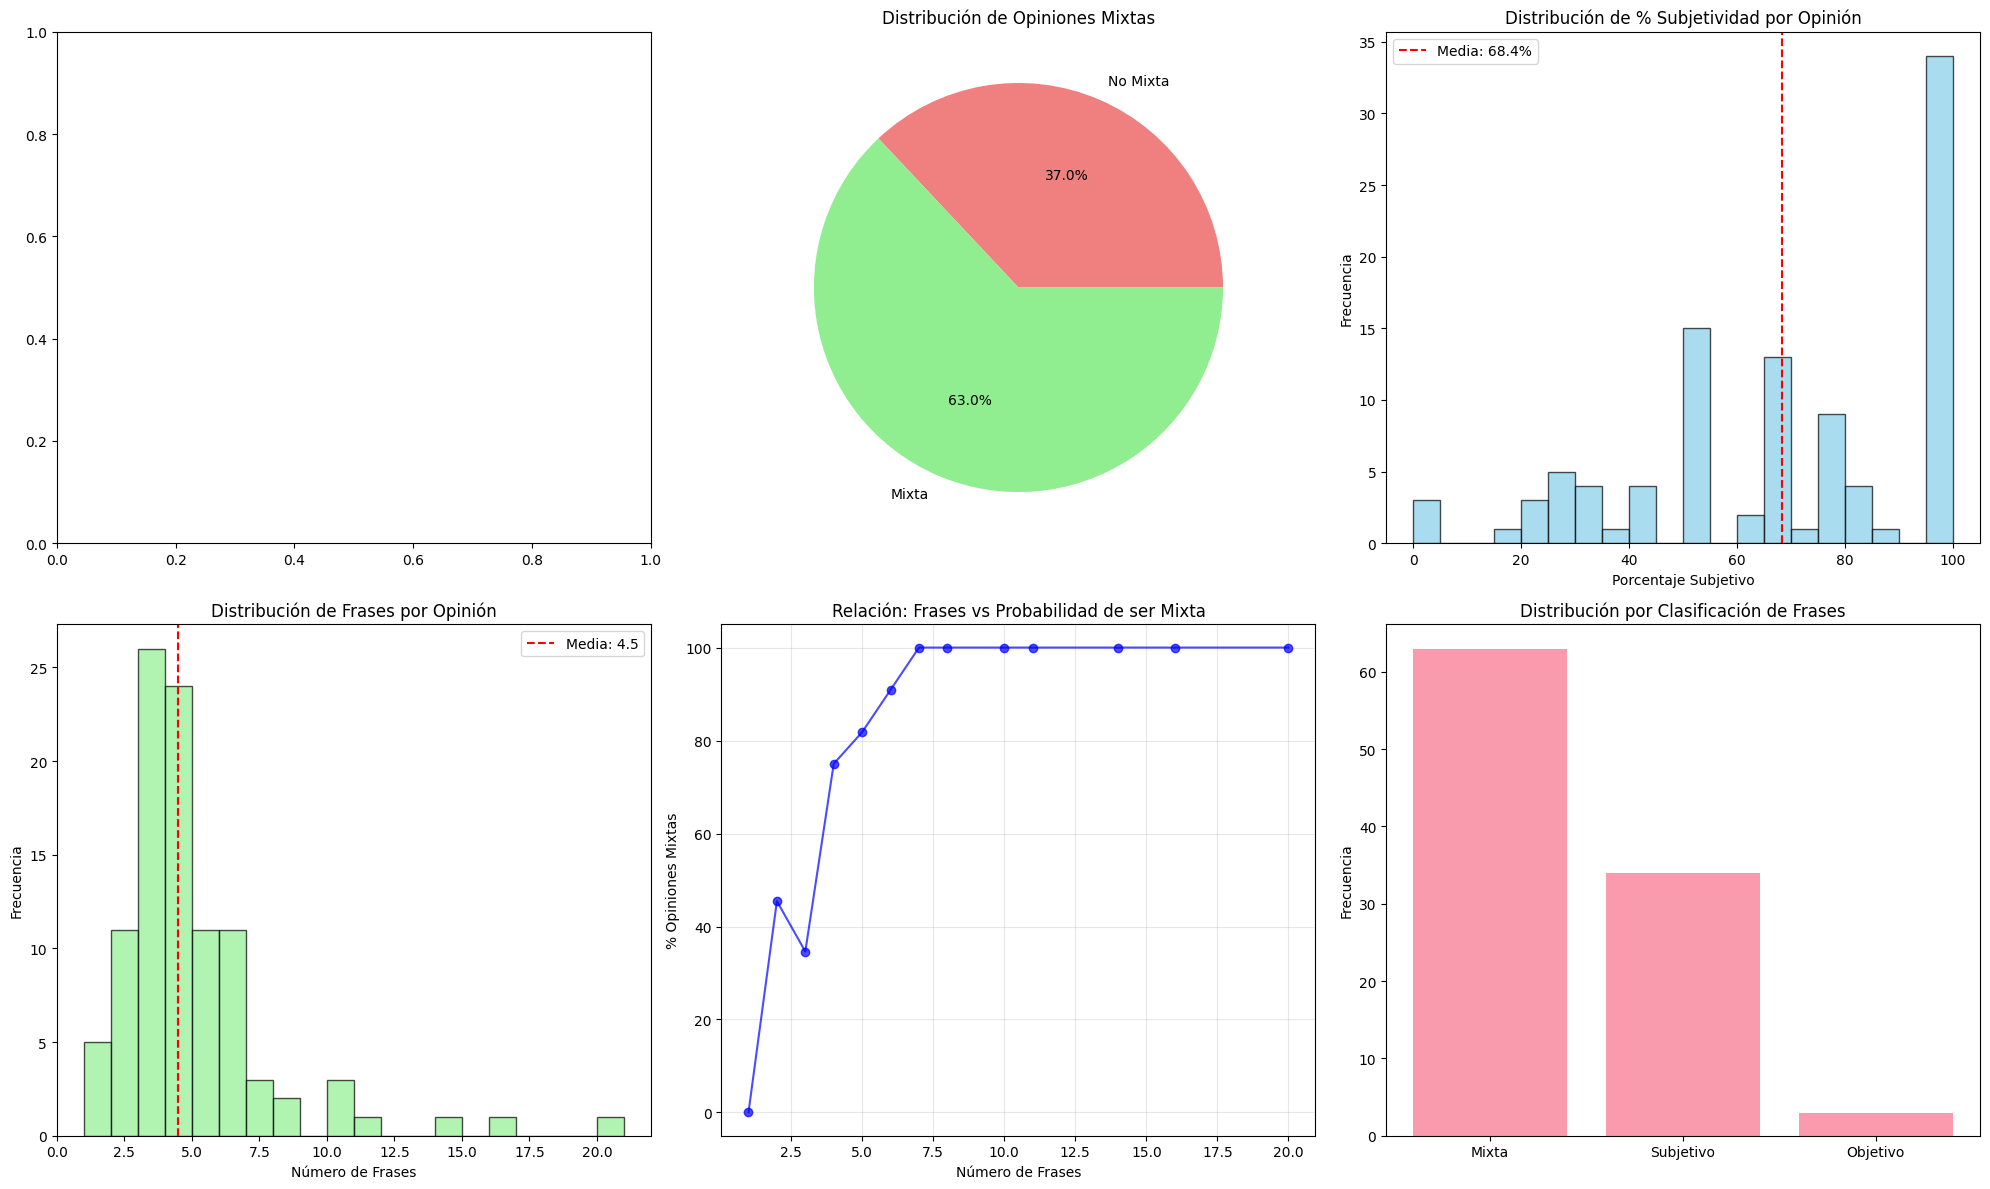


📊 ESTADÍSTICAS VISUALIZADAS:
----------------------------------------
• Promedio de frases por opinión: 4.50
• Mediana de frases por opinión: 4
• Porcentaje promedio de subjetividad: 68.4%
• Porcentaje promedio de objetividad: 31.6%
• Correlación entre número de frases y ser mixta: 0.413
• % de opiniones mixtas en textos de 3+ frases: 69.0%
✅ Visualizaciones generadas exitosamente


In [10]:
# Crear visualizaciones de los resultados
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('default')
sns.set_palette("husl")

print("📈 CREANDO VISUALIZACIONES DE LOS RESULTADOS")
print("=" * 60)

# Configurar figura con subplots
fig = plt.figure(figsize=(20, 12))

# 1. Comparación de distribuciones
ax1 = plt.subplot(2, 3, 1)
if 'SubjetividadHF' in df_analisis.columns:
    # Datos para comparación
    original_counts = df_analisis['SubjetividadHF'].value_counts()
    frases_counts = df_analisis['ClasificacionPorFrases'].value_counts()
    
    # Preparar datos para gráfico comparativo
    categorias = ['Objetivo', 'Subjetivo', 'Mixta']
    original_values = [original_counts.get(cat, 0) for cat in ['Objetivo', 'Subjetivo']] + [0]
    frases_values = [frases_counts.get(cat, 0) for cat in categorias]
    
    x = np.arange(len(categorias))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, original_values, width, label='Análisis Original', alpha=0.8)
    bars2 = ax1.bar(x + width/2, frases_values, width, label='Análisis por Frases', alpha=0.8)
    
    ax1.set_xlabel('Categorías')
    ax1.set_ylabel('Número de Opiniones')
    ax1.set_title('Comparación: Original vs Por Frases')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categorias)
    ax1.legend()
    
    # Agregar valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

# 2. Distribución de opiniones mixtas
ax2 = plt.subplot(2, 3, 2)
mixtas_labels = ['No Mixta', 'Mixta']
mixtas_counts = df_analisis['EsMixta'].value_counts()
mixtas_values = [mixtas_counts.get(False, 0), mixtas_counts.get(True, 0)]
colors = ['lightcoral', 'lightgreen']

wedges, texts, autotexts = ax2.pie(mixtas_values, labels=mixtas_labels, autopct='%1.1f%%', colors=colors)
ax2.set_title('Distribución de Opiniones Mixtas')

# 3. Distribución de porcentajes de subjetividad
ax3 = plt.subplot(2, 3, 3)
ax3.hist(df_analisis['PorcentajeSubjetivo'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('Porcentaje Subjetivo')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de % Subjetividad por Opinión')
ax3.axvline(df_analisis['PorcentajeSubjetivo'].mean(), color='red', linestyle='--', label=f'Media: {df_analisis["PorcentajeSubjetivo"].mean():.1f}%')
ax3.legend()

# 4. Distribución de número de frases por opinión
ax4 = plt.subplot(2, 3, 4)
ax4.hist(df_analisis['TotalFrases'], bins=range(1, max(df_analisis['TotalFrases'])+2), alpha=0.7, color='lightgreen', edgecolor='black')
ax4.set_xlabel('Número de Frases')
ax4.set_ylabel('Frecuencia')
ax4.set_title('Distribución de Frases por Opinión')
ax4.axvline(df_analisis['TotalFrases'].mean(), color='red', linestyle='--', label=f'Media: {df_analisis["TotalFrases"].mean():.1f}')
ax4.legend()

# 5. Relación entre número de frases y probabilidad de ser mixta
ax5 = plt.subplot(2, 3, 5)
frases_por_mixta = df_analisis.groupby('TotalFrases')['EsMixta'].mean()
ax5.plot(frases_por_mixta.index, frases_por_mixta.values * 100, 'bo-', alpha=0.7)
ax5.set_xlabel('Número de Frases')
ax5.set_ylabel('% Opiniones Mixtas')
ax5.set_title('Relación: Frases vs Probabilidad de ser Mixta')
ax5.grid(True, alpha=0.3)

# 6. Matriz de confusión (si hay datos originales)
ax6 = plt.subplot(2, 3, 6)
if 'SubjetividadHF' in df_analisis.columns:
    # Crear matriz de confusión simplificada
    confusion_data = pd.crosstab(df_analisis['SubjetividadHF'], df_analisis['ClasificacionPorFrases'], margins=True)
    
    # Eliminar la fila/columna de totales para el heatmap
    confusion_matrix = confusion_data.iloc[:-1, :-1]
    
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax6)
    ax6.set_title('Matriz de Confusión:\nOriginal vs Por Frases')
    ax6.set_xlabel('Clasificación por Frases')
    ax6.set_ylabel('Clasificación Original')
else:
    # Si no hay datos originales, mostrar distribución simple
    dist_data = df_analisis['ClasificacionPorFrases'].value_counts()
    ax6.bar(dist_data.index, dist_data.values, alpha=0.7)
    ax6.set_title('Distribución por Clasificación de Frases')
    ax6.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n📊 ESTADÍSTICAS VISUALIZADAS:")
print("-" * 40)
print(f"• Promedio de frases por opinión: {df_analisis['TotalFrases'].mean():.2f}")
print(f"• Mediana de frases por opinión: {df_analisis['TotalFrases'].median():.0f}")
print(f"• Porcentaje promedio de subjetividad: {df_analisis['PorcentajeSubjetivo'].mean():.1f}%")
print(f"• Porcentaje promedio de objetividad: {df_analisis['PorcentajeObjetivo'].mean():.1f}%")

# Correlaciones interesantes
correlacion_frases_mixta = df_analisis['TotalFrases'].corr(df_analisis['EsMixta'].astype(int))
print(f"• Correlación entre número de frases y ser mixta: {correlacion_frases_mixta:.3f}")

if len(df_analisis[df_analisis['TotalFrases'] >= 3]) > 0:
    mixtas_en_largas = df_analisis[df_analisis['TotalFrases'] >= 3]['EsMixta'].mean() * 100
    print(f"• % de opiniones mixtas en textos de 3+ frases: {mixtas_en_largas:.1f}%")

print("✅ Visualizaciones generadas exitosamente")

In [11]:
# Conclusiones finales y validación de la hipótesis
print("🏆 CONCLUSIONES FINALES Y VALIDACIÓN DE HIPÓTESIS")
print("=" * 80)

# Calcular métricas clave para la validación
total_opiniones = len(df_analisis)
opiniones_mixtas = len(df_analisis[df_analisis['EsMixta'] == True])
porcentaje_mixtas = (opiniones_mixtas / total_opiniones) * 100

# Análisis de reclasificación si hay datos originales
if 'SubjetividadHF' in df_analisis.columns:
    # Opiniones que fueron reclasificadas
    originalmente_subjetivas = df_analisis[df_analisis['SubjetividadHF'] == 'Subjetivo']
    subjetivas_a_mixtas = len(originalmente_subjetivas[originalmente_subjetivas['ClasificacionPorFrases'] == 'Mixta'])
    subjetivas_a_objetivas = len(originalmente_subjetivas[originalmente_subjetivas['ClasificacionPorFrases'] == 'Objetivo'])
    
    originalmente_objetivas = df_analisis[df_analisis['SubjetividadHF'] == 'Objetivo']
    objetivas_a_mixtas = len(originalmente_objetivas[originalmente_objetivas['ClasificacionPorFrases'] == 'Mixta'])
    
    print("📊 RESULTADOS DE LA VALIDACIÓN:")
    print("-" * 50)
    print(f"• Total de opiniones analizadas: {total_opiniones}")
    print(f"• Opiniones mixtas detectadas: {opiniones_mixtas} ({porcentaje_mixtas:.1f}%)")
    print(f"• Opiniones originalmente subjetivas reclasificadas como mixtas: {subjetivas_a_mixtas}")
    print(f"• Opiniones originalmente subjetivas reclasificadas como objetivas: {subjetivas_a_objetivas}")
    print(f"• Opiniones originalmente objetivas reclasificadas como mixtas: {objetivas_a_mixtas}")
    
    # Calcular ganancia en información objetiva
    info_objetiva_original = len(df_analisis[df_analisis['SubjetividadHF'] == 'Objetivo'])
    info_objetiva_nueva = len(df_analisis[df_analisis['ClasificacionPorFrases'].isin(['Objetivo', 'Mixta'])])
    ganancia_info = info_objetiva_nueva - info_objetiva_original
    
    print(f"\n💡 GANANCIA EN INFORMACIÓN OBJETIVA:")
    print(f"• Información objetiva original: {info_objetiva_original} opiniones")
    print(f"• Información objetiva nueva (Objetivo + Mixta): {info_objetiva_nueva} opiniones")
    print(f"• Ganancia neta: {ganancia_info} opiniones (+{(ganancia_info/total_opiniones)*100:.1f}%)")

# Determinar si la hipótesis se confirma
umbral_significativo = 15  # Porcentaje mínimo para considerar significativo

print(f"\n🎯 VALIDACIÓN DE LA HIPÓTESIS:")
print("-" * 40)
print(f"HIPÓTESIS: 'Las opiniones turísticas son frecuentemente mixtas, lo que explica")
print(f"la baja proporción de opiniones objetivas en el análisis tradicional'")
print()

if porcentaje_mixtas >= umbral_significativo:
    print(f"✅ HIPÓTESIS CONFIRMADA")
    print(f"   • {porcentaje_mixtas:.1f}% de las opiniones son mixtas (≥{umbral_significativo}%)")
    print(f"   • Esto explica por qué el análisis tradicional encuentra pocas opiniones objetivas")
    print(f"   • Las opiniones mixtas contienen información valiosa tanto subjetiva como objetiva")
elif porcentaje_mixtas >= 10:
    print(f"🔶 HIPÓTESIS PARCIALMENTE CONFIRMADA")
    print(f"   • {porcentaje_mixtas:.1f}% de las opiniones son mixtas (moderado)")
    print(f"   • Hay evidencia de que las opiniones mixtas contribuyen al problema")
    print(f"   • Se necesita análisis adicional para confirmar completamente")
else:
    print(f"❌ HIPÓTESIS NO CONFIRMADA")
    print(f"   • Solo {porcentaje_mixtas:.1f}% de las opiniones son mixtas (<10%)")
    print(f"   • La baja proporción de opiniones objetivas puede tener otras causas")
    print(f"   • Se requiere investigación adicional")

# Implicaciones para el análisis turístico
print(f"\n🎯 IMPLICACIONES PARA EL ANÁLISIS TURÍSTICO:")
print("-" * 50)

# Calcular frases objetivas recuperadas
total_frases_objetivas = df_analisis['FrasesObjetivas'].sum()
opiniones_con_info_objetiva = len(df_analisis[df_analisis['FrasesObjetivas'] > 0])

print(f"📈 BENEFICIOS DEL ANÁLISIS POR FRASES:")
print(f"   • Se identificaron {total_frases_objetivas} frases con información objetiva")
print(f"   • {opiniones_con_info_objetiva} opiniones contienen al menos una frase objetiva")
print(f"   • {porcentaje_mixtas:.1f}% de opiniones proporcionan información mixta valiosa")

print(f"\n💼 VALOR PARA TURISTÓLOGOS:")
print(f"   • Mayor extracción de información factual útil")
print(f"   • Mejor comprensión de patrones en opiniones turísticas")
print(f"   • Posibilidad de separar emociones de hechos en las reseñas")
print(f"   • Datos más ricos para toma de decisiones turísticas")

# Recomendaciones
print(f"\n🔧 RECOMENDACIONES PARA ANÁLISIS FUTUROS:")
print("-" * 45)
print(f"1. 🎯 Implementar análisis por frases en datasets completos")
print(f"2. 📊 Usar la categoría 'Mixta' en clasificaciones de subjetividad")
print(f"3. 🔍 Desarrollar métricas específicas para contenido mixto")
print(f"4. 📝 Extraer frases objetivas para análisis de características turísticas")
print(f"5. 🌟 Combinar información subjetiva y objetiva para insights más completos")

# Guardar resultados
print(f"\n💾 EXPORTACIÓN DE RESULTADOS:")
print("-" * 30)
archivo_salida = '../data/processed/analisis_opiniones_mixtas.csv'
df_analisis.to_csv(archivo_salida, index=False)
print(f"✅ Resultados guardados en: {archivo_salida}")
print(f"📊 Columnas incluidas: {list(df_analisis.columns)}")

print(f"\n" + "🏆" * 30 + " ANÁLISIS COMPLETADO " + "🏆" * 30)
print("=" * 80)
print(f"✅ Validación de hipótesis sobre opiniones mixtas completada")
print(f"📊 Metodología de análisis por frases implementada exitosamente")
print(f"🎯 Resultados disponibles para investigación adicional")
print("=" * 80)

🏆 CONCLUSIONES FINALES Y VALIDACIÓN DE HIPÓTESIS

🎯 VALIDACIÓN DE LA HIPÓTESIS:
----------------------------------------
HIPÓTESIS: 'Las opiniones turísticas son frecuentemente mixtas, lo que explica
la baja proporción de opiniones objetivas en el análisis tradicional'

✅ HIPÓTESIS CONFIRMADA
   • 63.0% de las opiniones son mixtas (≥15%)
   • Esto explica por qué el análisis tradicional encuentra pocas opiniones objetivas
   • Las opiniones mixtas contienen información valiosa tanto subjetiva como objetiva

🎯 IMPLICACIONES PARA EL ANÁLISIS TURÍSTICO:
--------------------------------------------------
📈 BENEFICIOS DEL ANÁLISIS POR FRASES:
   • Se identificaron 175 frases con información objetiva
   • 66 opiniones contienen al menos una frase objetiva
   • 63.0% de opiniones proporcionan información mixta valiosa

💼 VALOR PARA TURISTÓLOGOS:
   • Mayor extracción de información factual útil
   • Mejor comprensión de patrones en opiniones turísticas
   • Posibilidad de separar emociones de